In [15]:
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA

import os
import sys

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

from settings import DATA_DIR, MODEL_DIR
from src.utils import transform

## Load data into memory

In [3]:
file = os.path.join(DATA_DIR, 'era5_west_pacific_sst.nc')
ds = xr.open_dataset(file)
arr = ds['sst'].mean(dim='expver')[:, ::2, ::2]  # Half resolution
ds.close()

# Remove seasonality and trend

In [6]:
rem_seas = transform.SeasonalityRemoverFFT(div_std=True, fft_keep_frac=0.03).fit(arr)
deseas = rem_seas.transform(arr)

rem_trend = transform.TrendRemover().fit(deseas)
detr = rem_trend.transform(deseas)

Text(0, 0.5, 'lat')

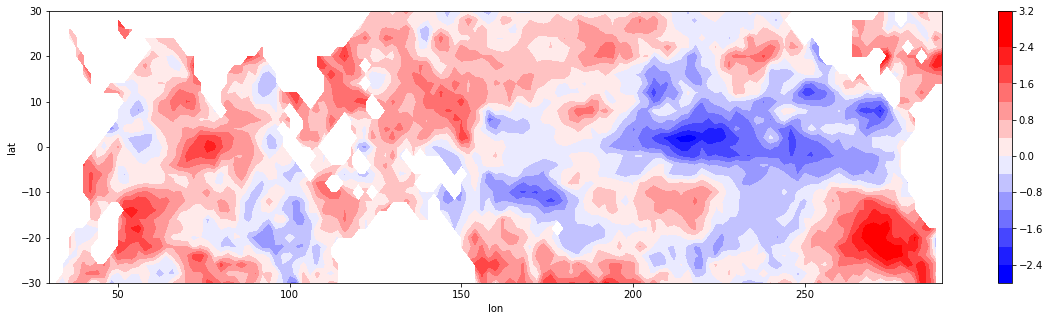

In [7]:
plt.figure(figsize=[20, 5])
c = plt.contourf(detr.coords['longitude'], detr.coords['latitude'], detr[850, :, :], cmap='bwr', vmin=-2.5, vmax=2.5, levels=15)
plt.colorbar(c)
plt.xlabel('lon')
plt.ylabel('lat')

# Perform PCA, take a look at EOFs to make sure they make sense. 

Convert to DF and perform PCA. Turn EOFs back into a DataArray so we can visualize them properly. They seem reasonable to me. 

In [96]:
da2df = transform.DataArray2DataFrame(time_dim='time').fit(detr)
df = da2df.transform(detr).dropna(how='all', axis=1)

In [119]:
n_components = 30
pca = PCA(n_components=n_components).fit(df.values)


In [120]:
eof_df = pd.DataFrame(
    index=pd.RangeIndex(0, n_components, name='eof'), 
    columns=df.columns, 
    data=pca.components_
)
eof_da = da2df.inverse_transform(eof_df)

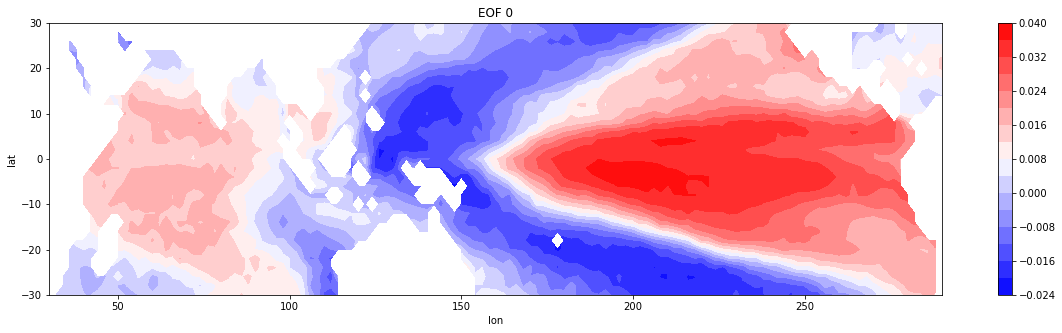

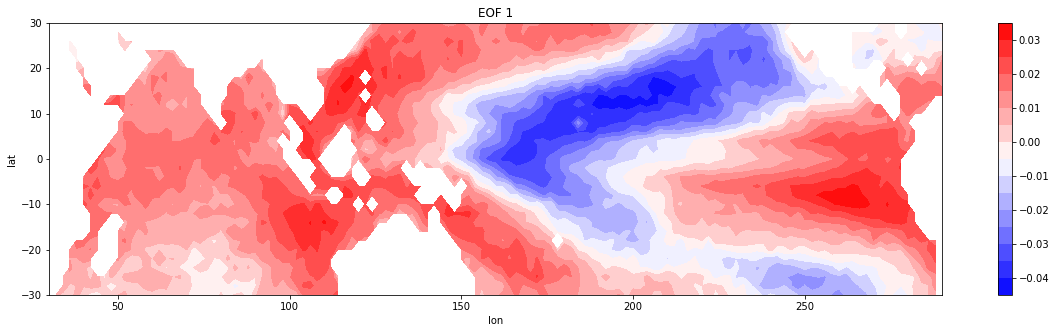

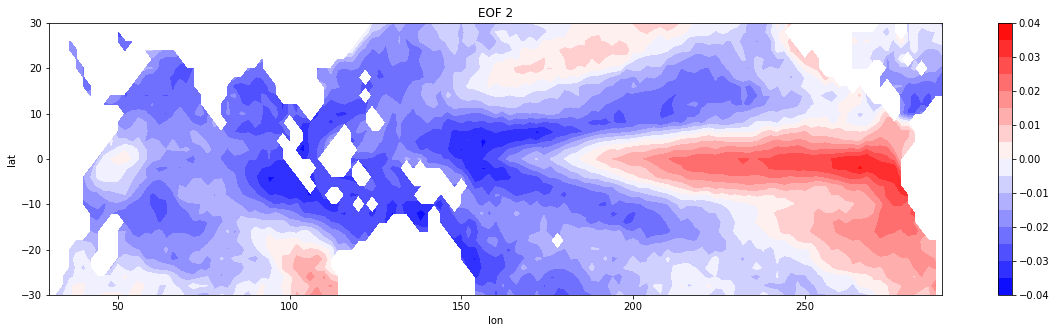

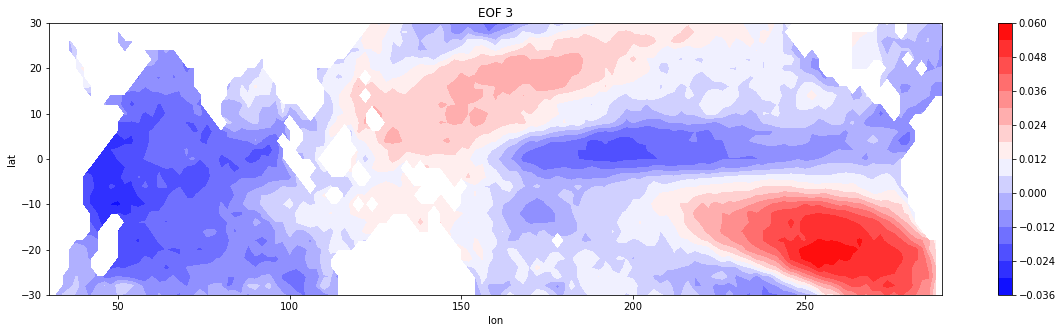

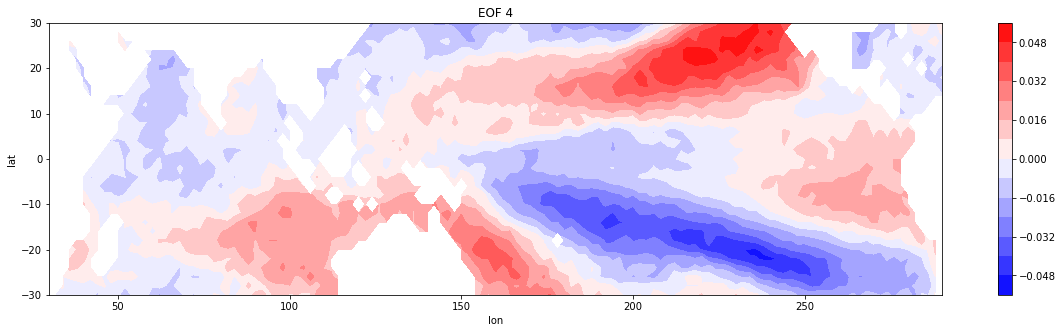

In [68]:
for n_eof in range(5): 
    plt.figure(figsize=[20, 5])
    c = plt.contourf(
        eof_da.coords['longitude'], 
        eof_da.coords['latitude'], 
        eof_da.isel(eof=n_eof), 
        cmap='bwr', levels=15
    )
    plt.colorbar(c)
    plt.xlabel('lon')
    plt.ylabel('lat')
    plt.title(f'EOF {n_eof}')
    plt.show()

# Figure out how to find EOF weightings from partial data

Create some holes in the raw data (T). 
* Find weights w that minimize error = t - E.T @ w, where t is known temperatures, E is EOFs at locations of known temperatures, and w is a vector of weights. 
* Then multiply P.T @ w, where P is matrix of EOFs at all points, to get estimated values at all points. 
* Use that to impute

In [125]:
from scipy.linalg import lstsq

test_idx = 0

# Observation vector with NaNs. 
t = df.iloc[test_idx].copy()
exclude = np.random.uniform(0, 1, size=t.shape) > 0.5
t[exclude] = np.nan
t = t.dropna()

# EOF 
E = eof_df.reindex(t.index, axis=1)
w, _, _, _ = lstsq(E.T, t)
t_hat = eof_df.T @ w



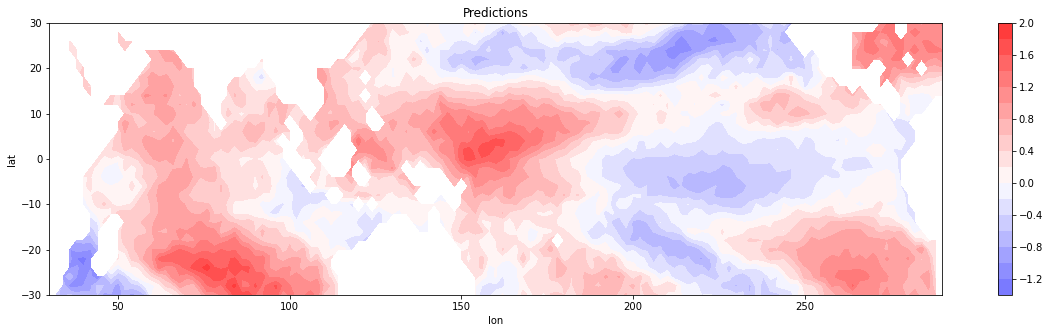

In [126]:
tmp = t_hat.to_frame().T
tmp.index.name = 'time'
preds_da = da2df.inverse_transform(tmp)

plt.figure(figsize=[20, 5])
c = plt.contourf(
    preds_da.coords['longitude'], 
    preds_da.coords['latitude'], 
    preds_da.isel(time=test_idx), 
    vmin=-2.5, vmax=2.5, 
    cmap='bwr', levels=15
)
plt.colorbar(c)
plt.xlabel('lon')
plt.ylabel('lat')
plt.title(f'Predictions')
plt.show()

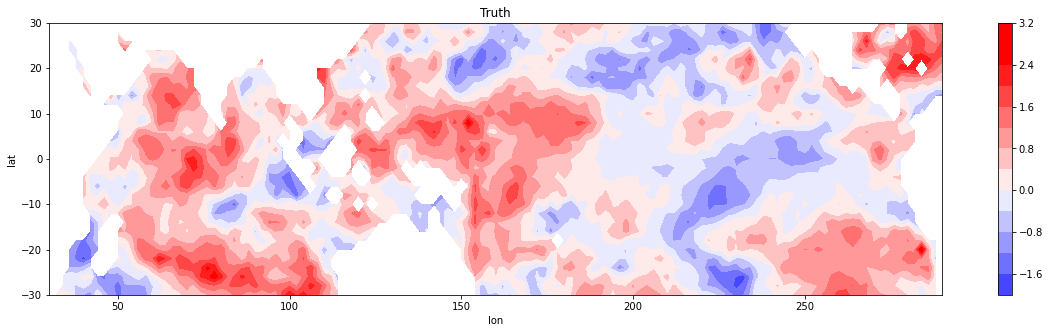

In [127]:
plt.figure(figsize=[20, 5])
c = plt.contourf(
    detr.coords['longitude'], 
    detr.coords['latitude'], 
    detr.isel(time=test_idx), 
    vmin=-2.5, vmax=2.5, 
    cmap='bwr', levels=15
)
plt.colorbar(c)
plt.xlabel('lon')
plt.ylabel('lat')
plt.title(f'Truth')
plt.show()

# Work on full process
* Start with data that has gaps. 
* Use weighted PCA to find EOFs
* Find EOF weights at each time. 
* Use EOF weights to predict SSTs at each time step. 
* Use predictions to impute values. 
* Evaluate error. 

That looks damn good in my opinion! The predictions aren't perfect (only using 50% of points and top 30 EOFs) but the similarity is very clear! 